In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import seaborn as sns
import os

C:\Users\Hp\Desktop\Data Science\My Projects\FakeNewsDetection\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
base_dir = os.getcwd()  # Get the script's directory
output_dir = os.path.join(base_dir, "..", "..", "output")

file_path1 = os.path.join(output_dir, "auto_labeled_data.xlsx")
df1 = pd.read_excel(file_path1)

In [5]:
texts = df1['Combined_text'].dropna().tolist()

In [6]:
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(texts, show_progress_bar=True)

Batches: 100%|██████████| 68/68 [00:38<00:00,  1.76it/s]


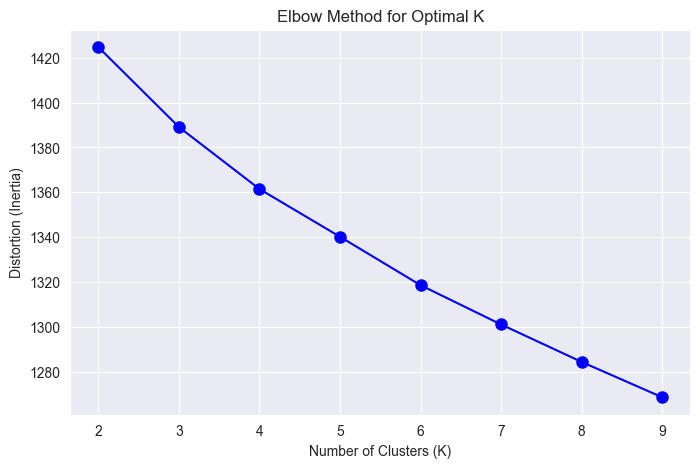

In [8]:
# Elbow Method
distortions = []
K = range(2, 10)  # Testing clusters from 2 to 10
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(embeddings)
    distortions.append(kmeans.inertia_)  # Sum of squared distances

# Plot Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(K, distortions, 'bo-', markersize=8)
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Distortion (Inertia)')
plt.title('Elbow Method for Optimal K')
plt.show()

In [13]:
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df1['Cluster'] = kmeans.fit_predict(embeddings)

In [14]:
print(df1['Cluster'].value_counts())

# Sample texts from each cluster
for i in range(optimal_k):
    print(f"\nCluster {i} Example Texts:")
    print(df1[df1['Cluster'] == i]['Combined_text'].sample(3, random_state=42).tolist())

Cluster
0    826
1    756
2    581
Name: count, dtype: int64

Cluster 0 Example Texts:
['[\u200c](https://twitter.com/hashtag/AmsterdamPogrom)\nThe IDF has cancelled the rescue mission to Amsterdam. This change reportedly stemmed from fears that Israeli soldiers could face legal action at the behest of anti-Israel organizations were they to land and operate on Dutch soil. [#AmsterdamPogrom](https://twitter.com/hashtag/AmsterdamPogrom) [#Israel](https://twitter.com/hashtag/Israel)\n\n**@Israel**  ', 'JUST IN 🚨🚨\n\nUS House Passes Bill to Sanction ICC Over Netanyahu and Gallant Arrest Warrants\n\n**@Israel**  ', 'IDF Chief of Staff Lt. Gen. Herzi Halevi has notified Defense Minister Israel Katz that he intends to resign on March 6.  ']

Cluster 1 Example Texts:
['Two drones launched from Iraq at Israel were shot down by the Israeli Air Force a short while ago, the military says.\n\nOne of the drones entered Israeli airspace in the Arava Desert, close to Ramon Airport, setting off sirens 

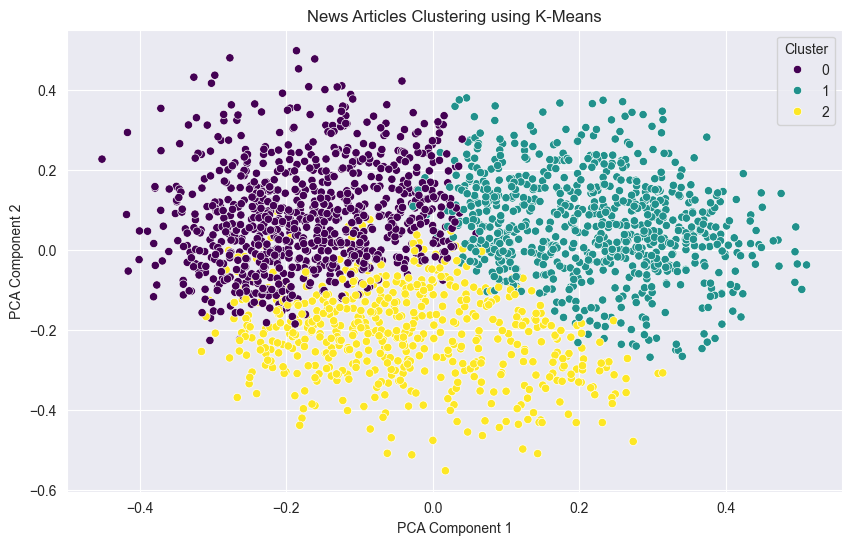

In [17]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=reduced_embeddings[:, 0], y=reduced_embeddings[:, 1], hue=df1['Cluster'], palette='viridis')
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("News Articles Clustering using K-Means")
plt.savefig(os.path.join(output_dir, "K_means_cluster.png"), dpi=300)
plt.show()

In [16]:
df1.head()

,Message_ID,Date,Combined_text,Total_Comments,Text_Positive_Reactions,Text_Negative_Reactions,Cluster
0,13116,2025-01-02 23:28:31,"IDF: Over the past hour, terrorists hurled roc...","IDF: Over the past hour, terrorists hurled roc...",3,65,1
1,13115,2025-01-02 23:20:32,"🇺🇸🇮🇷⚡️- ""Biden discussed plans to strike Iran ...",['Biden/Obama are responsible for a lot of wha...,1,65,0
2,13114,2025-01-01 18:40:48,Former Israeli defence minister Yoav Gallant h...,['A Zionist Jew and an Anti Zionist Jew walk i...,80,0,0
3,13113,2025-01-01 18:40:38,"Gallant announced his retirement: ""There are m...","['Pls, do! U have obviously overstayed ur welc...",23,11,0
4,13112,2025-01-01 18:40:07,"🇵🇸🇮🇱⚡- ""If Hamas does not allow the release of...","['Welp... We know who you voted for!!', 'https...",0,27,0


In [18]:
file_path2 = os.path.join(output_dir, "final_data_after_clustering.xlsx")
df1.to_excel(file_path2, index=False)